Determine whether outbound calls increase the likelihood that a new account holder purchases a car within 45 days, and use that insight to rank eligible customers for calling so the campaign maximizes net value after dialing cost ($0.10 per dial).

Import packages

In [27]:
from pathlib import Path
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# !pip -q install xgboost
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency
from scipy.stats import norm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix, make_scorer
from sklearn.metrics import precision_recall_curve, brier_score_loss, log_loss
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterSampler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer

pd.set_option("display.max_columns", 200)
import warnings
warnings.filterwarnings("ignore")
os.environ["LOKY_MAX_CPU_COUNT"] = str(os.cpu_count() or 1)
warnings.filterwarnings("ignore", message=".*wmic.*")

# Data

In [2]:
base_dir = Path(r"..")

cust = pd.read_csv(base_dir / "CustomerHistory.csv")
calls = pd.read_csv(base_dir / "OBCallHistory.csv")
sales = pd.read_csv(base_dir / "SaleHistory.csv")

print("CustomerHistory:", cust.shape)
print("OBCallHistory:  ", calls.shape)
print("SaleHistory:    ", sales.shape)

CustomerHistory: (12010, 51)
OBCallHistory:   (7998, 5)
SaleHistory:     (5610, 4)


In [3]:
cust.head()

,userid,AttributedEmail,EmailVerified,GeneratedTerms,HasBureauError,HasStartedPurchase,InboundCall,InboundChat,InboundEmail,IsDealSeeker,IsDirtLover,IsDreamer,IsGreen,IsResearcher,MultipleEmail,OutboundEmail,ReferralAttachment,TradeInValueGenerated,InboundCallCount,InboundChatCount,InboundEmailCount,OutboundCallCount,OutboundEmailCount,TotalInboundCallLength,BureauIncome,CreditScore1,CreditScore2,DeviceCount,FraudScore,Income,MedianVehicleFuelEcon,MedianVehiclePrice,NumberSavedVehicles,NumberSearches,TradeInValueAmount,UniqueModels,VehicleVelocity1,VehicleVelocity15,VehicleVelocity30,CensusGeoRegionAddress,LeadSource,ModeDeviceType,ModeVehicleType,PhoneType,ServiceProvider,AgeCategory,ClicksQuintile,InboundCallContact,accountcreationdatetime,PhoneNumber_hashed,MedianVehicleMileage
0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,244.2,48155.503685,684,692,4,307,52091,17.9,29822.391554,8,7,6322.24,6,3,15,29,West,ThirdPartyListing,mobile,Car,PostPaid,Verizon,18-35,1,some,05FEB2018:13:48:45.56,NaN,36469.370904
1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,287.7,53775.160694,597,624,1,374,60105,26.4,22616.649917,4,5,3758.51,8,6,30,36,South,ThirdPartyListing,desktop,Car,PostPaid,TMobile,18-35,2,all,10JAN2018:23:51:20.47,FD6E960D1EFB31AFD2E65E71A51CC9475E25BFEE74E804...,42399.404151
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,273.9,29681.705776,632,652,4,351,23252,25.7,25796.395942,2,5,6567.97,9,8,22,34,South,Website,tablet,Van,PostPaid,Sprint,18-35,3,all,09FEB2018:06:18:08.79,CC2448A8343314DB37B67319CE78AFCC18CE92C60E0337...,42875.869050
3,4,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,330.6,44150.101624,597,576,4,293,38006,23.9,21847.012250,6,7,8241.35,4,1,7,36,South,Website,mobile,Truck,Landline,Sprint,18-35,3,all,01JAN2018:17:33:51.52,0A47E42886E40E28D92A031457E5FF71155C160CEFBE8A...,31617.816357
4,5,0,1,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,356.8,41561.250333,670,681,2,327,49516,36.3,27079.906407,2,10,12080.61,5,7,13,37,Northeast,Website,tablet,Truck,PostPaid,Verizon,35-45,3,most,13JAN2018:06:31:57.81,308EAC272C9C8E0E718833956553728D3B1ABE02DD6D88...,52785.281802


In [4]:
calls.head()

,PhoneNumber_hashed,OBCallDateTime,Contacted,advocate_id,CallDuration
0,FD6E960D1EFB31AFD2E65E71A51CC9475E25BFEE74E804...,01FEB2018:10:23:10.20,1,2,0:28:11
1,CC2448A8343314DB37B67319CE78AFCC18CE92C60E0337...,13FEB2018:07:52:41.00,1,11,0:15:48
2,0A47E42886E40E28D92A031457E5FF71155C160CEFBE8A...,17JAN2018:14:00:10.29,1,13,0:23:00
3,308EAC272C9C8E0E718833956553728D3B1ABE02DD6D88...,05FEB2018:14:13:41.96,0,20,NaN
4,018F2F1107C2ADBFF7861EC337BA790B87BDFF1CCCA114...,09MAY2018:10:02:38.71,1,3,0:10:39


In [5]:
sales.head()

,userid,saledatetime,StickerPrice,Odometer
0,3,28FEB2018:10:06:33.17,"$28,352.27",18506
1,4,09FEB2018:00:50:44.95,"$25,145.55",13544
2,5,20FEB2018:19:58:49.75,"$28,809.16",20643
3,6,21MAR2018:11:35:48.21,"$27,561.91",12269
4,7,15MAY2018:07:21:36.45,"$28,340.72",14502


# Data Preparation and Feature Engineerin

In [7]:
sales["sticker_price"] = pd.to_numeric( sales["StickerPrice"].astype(str).str.replace(r"[^0-9.\-]", "", regex=True), errors="coerce") 

In [8]:
sales["sticker_price"].dtype

dtype('float64')

Construct a new binary variable to indicate whether a customer purchased a vehicle within 45 days of the time they created their account, call this variable “sold”.

In [9]:
df = (cust.merge(calls, on="PhoneNumber_hashed", how="left")
          .merge(sales, on="userid", how="left"))


In [10]:
def parse_dt(s):
    s = s.where(s.notna(), pd.NA).astype("string").str.strip()
    s = s.str.slice(0,2) + s.str.slice(2,5).str.title() + s.str.slice(5)  # FEB -> Feb
    return pd.to_datetime(s, format="%d%b%Y:%H:%M:%S.%f", errors="coerce")

df["accountcreationdatetime"] = parse_dt(df["accountcreationdatetime"])
df["saledatetime"] = parse_dt(df["saledatetime"])

# date-only columns (as timestamps at midnight)
df["accountcreationdate"] = df["accountcreationdatetime"].dt.floor("D")
df["sale_date"] = df["saledatetime"].dt.floor("D")

# sold within 45 days
df["sold"] = (
    df["sale_date"].notna()
    & (df["sale_date"] >= df["accountcreationdate"])
    & (df["sale_date"] <  df["accountcreationdate"] + pd.Timedelta(days=45))
).astype(int)


Construct a new binary variable to indicate if a customer’s CreditScore1 is above the median customer in the dataset; call this variable “high_credit”.

In [11]:
df["high_credit"] = (df["CreditScore1"] > df["CreditScore1"].median()).astype(int)

Construct a new binary variable to indicate if a customer’s income is above the 80th percentile; call this variable “high_income”.

In [12]:
df["high_income"] = (df["Income"] > df["Income"].quantile(0.8)).astype(int)

# Baseline Conversion by Outreach Status (Before Optimization)


In [13]:
# 1) attempted = did we attempt any outbound call for this customer?
df["attempted"] = df["OBCallDateTime"].notna().astype(int)

# 2) contacted = was the customer reached?
df["only_contacted"] = df["Contacted"].fillna(0).astype(int)

In [14]:
calls["Contacted"].value_counts(dropna=False)

Contacted
1    6278
0    1720
Name: count, dtype: int64

In [15]:
df["sold"].value_counts(dropna=False)

sold
0    7589
1    4421
Name: count, dtype: int64

In [16]:
# Conversion rate here means: (# customers who sold) / (total customers in that group).
conv_not_attempted = df.loc[df["attempted"] == 0, "sold"].mean()
conv_attempted = df.loc[df["attempted"] == 1, "sold"].mean()
conv_contacted = df.loc[df["only_contacted"] == 1, "sold"].mean()

print(f"Not attempted: {conv_not_attempted:.4%}")
print(f"Attempted: {conv_attempted:.4%}")
print(f"Contacted: {conv_contacted:.4%}")

Not attempted: 29.0379%
Attempted: 40.7102%
Contacted: 43.4055%


In [17]:
df["userid"].is_unique, df.shape

(True, (12010, 66))

# Statistical Validation of Baseline Differences

This step checks whether the observed differences in conversion rates across outreach groups are statistically distinguishable from random variation. Conversion is compared between groups (attempted vs. not attempted, and similarly for contacted) using standard proportion-based tests:

- Two-proportion z-test: tests whether conversion differs between two groups by comparing the means of a binary outcome.
- Chi-square test (2×2): tests whether conversion and group membership (e.g., attempted vs. not attempted) are independent.
- 95% confidence interval for lift: estimates the absolute difference in conversion rates and its uncertainty; if the interval excludes zero, the lift is unlikely to be due to chance.
- Permutation (randomization) test: shuffles group labels many times to estimate how often a lift as large as observed occurs under random labeling (two-sided, nonparametric p-value).

In [18]:
# 1) proportion tests
# Attempted vs Not attempted
g1 = df[df["attempted"] == 1]["sold"]
g2 = df[df["attempted"] == 0]["sold"]

# counts for z-test
count = np.array([g1.sum(), g2.sum()])              # sold
nobs  = np.array([g1.shape[0], g2.shape[0]])        # total in group

# 1.1) Two-proportion z-test
z_stat, p_val = proportions_ztest(count, nobs, alternative="two-sided")
print("Two-proportion z-test (attempted vs not attempted)")
print("z =", z_stat, "p =", p_val)

# 1.2) Chi-square test (2x2 contingency table)
table = pd.crosstab(df["attempted"], df["sold"])    # rows: attempted(0/1), cols: sold(0/1)
chi2, p, dof, expected = chi2_contingency(table)
print("\nChi-square test (attempted vs sold)")
print("chi2 =", chi2, "p =", p)
print("\nContingency table:\n", table)


Two-proportion z-test (attempted vs not attempted)
z = 12.509681305499212 p = 6.608884432920232e-36

Chi-square test (attempted vs sold)
chi2 = 155.99072123937086 p = 8.505407237692063e-36

Contingency table:
 sold          0     1
attempted            
0          2847  1165
1          4742  3256


The results show a clear and statistically significant difference in purchase conversion between customers who were attempted by the outbound calling campaign and those who were not. In the data, 40.7% of attempted customers purchased within the window (3,256/7,998) compared to 29.0% of not-attempted customers (1,165/4,012), an absolute lift of about +11.7 percentage points. Both a two-proportion z-test (z = 12.51, p ≈ 6.6×10⁻³⁶) and an equivalent chi-square test of independence (χ² = 155.99, p ≈ 8.5×10⁻³⁶) indicate that this difference is extremely unlikely to be due to random chance.

In [19]:
# 2) Confidence intervals for the lift
def lift_ci_95(sold_a, sold_b):
    # sold_a, sold_b are 0/1 Series for two groups
    n1, n2 = sold_a.shape[0], sold_b.shape[0]
    p1, p2 = sold_a.mean(), sold_b.mean()
    lift = p1 - p2

    # standard error for difference in proportions (Wald CI)
    se = np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    z = 1.96  # 95%
    lo, hi = lift - z*se, lift + z*se
    return p1, p2, lift, lo, hi

# Attempted vs Not attempted
g1 = df.loc[df["attempted"] == 1, "sold"]
g2 = df.loc[df["attempted"] == 0, "sold"]

p1, p2, lift, lo, hi = lift_ci_95(g1, g2)

print(f"p(attempted)      = {p1:.4%}")
print(f"p(not attempted)  = {p2:.4%}")
print(f"lift (abs)        = {lift:.4%}")
print(f"95% CI for lift   = [{lo:.4%}, {hi:.4%}]")


p(attempted)      = 40.7102%
p(not attempted)  = 29.0379%
lift (abs)        = 11.6723%
95% CI for lift   = [9.9024%, 13.4422%]


The 95% confidence interval analysis quantifies the uncertainty around the observed conversion-rate lift for the outbound campaign. Customers who were attempted converted at 40.71%, compared to 29.04% for those not attempted, yielding an absolute lift of +11.67 percentage points. The 95% CI for the lift is [9.90%, 13.44%], which does not include 0—indicating that the higher conversion rate among attempted customers is very unlikely to be due to random chance and that the true underlying lift is plausibly around ~10–13 percentage points in this sample.

 **Permutation / randomization test (nonparametric)**
it’s a valid “difference-in-means under random labeling” check
it answer if attempted labels were randomly assigned (no real relationship), how often would we see a lift as large as the observed one?

In [20]:
y = df["sold"].to_numpy()
g = df["attempted"].to_numpy() 
n1 = g.sum()

obs_lift = y[g==1].mean() - y[g==0].mean()

R = 20000  # permutations
rng = np.random.default_rng(0)
count = 0

for _ in range(R):
    g_perm = rng.permutation(g)         # shuffle labels, keep same group sizes
    lift = y[g_perm==1].mean() - y[g_perm==0].mean()
    if abs(lift) >= abs(obs_lift):      # two-sided
        count += 1

p_perm = (count + 1) / (R + 1)          # add-one smoothing

print("Observed lift:", obs_lift)
print("Permutation p-value:", p_perm)


Observed lift: 0.11672291203409024
Permutation p-value: 4.999750012499375e-05


The permutation test shows that the observed lift of 0.1167 (about 11.7 percentage points) is extremely unlikely to occur by chance under random labeling. The permutation p-value (~5×10⁻⁵) means only about 0.005% of shuffled runs produced a lift as large as the one observed, providing strong statistical evidence that the conversion difference between the two groups is not explained by random variation alone.

## Conversion Lift by Customer Segment (Credit and Income)
- a. Does the impact of a call on sale conversion rate differ for customers who are “high_credit” relative to those who are not? Could any difference be due to chance? 
- b. Does the impact of a call on sale conversion rate differ for customers who are “high_income” relative to those who are not? Could any difference be due to chance? 

In [21]:
# Define treatment/control for "call impact":
#   treatment  = only_contacted == 1
#   control    = attempted == 0 (not attempted)

def lift_ztest_ci(df_seg, treat_mask, ctrl_mask, sold_col="sold"):
    t = df_seg.loc[treat_mask, sold_col].dropna()
    c = df_seg.loc[ctrl_mask, sold_col].dropna()

    p_t, p_c = t.mean(), c.mean()
    lift = p_t - p_c

    # z-test for difference in proportions
    count = np.array([t.sum(), c.sum()])
    nobs  = np.array([t.shape[0], c.shape[0]])
    z, p = proportions_ztest(count, nobs, alternative="two-sided")

    # 95% Wald CI for lift
    se = np.sqrt(p_t*(1-p_t)/nobs[0] + p_c*(1-p_c)/nobs[1])
    lo, hi = lift - 1.96*se, lift + 1.96*se

    return {
        "n_treat": int(nobs[0]), "n_ctrl": int(nobs[1]),
        "p_treat": p_t, "p_ctrl": p_c,
        "lift": lift, "ci_lo": lo, "ci_hi": hi,
        "z": float(z), "pval": float(p)
    }

# segment masks
is_high = df["high_credit"] == 1
is_low  = df["high_credit"] == 0

treat = df["only_contacted"] == 1
ctrl  = df["attempted"] == 0

res_low  = lift_ztest_ci(df[is_low],  treat[is_low],  ctrl[is_low])
res_high = lift_ztest_ci(df[is_high], treat[is_high], ctrl[is_high])

print("LOW credit (high_credit=0):")
print(res_low)
print("\nHIGH credit (high_credit=1):")
print(res_high)

LOW credit (high_credit=0):
{'n_treat': 3122, 'n_ctrl': 2044, 'p_treat': np.float64(0.44907110826393337), 'p_ctrl': np.float64(0.16095890410958905), 'lift': np.float64(0.28811220415434435), 'ci_lo': np.float64(0.2644848078162598), 'ci_hi': np.float64(0.3117396004924289), 'z': 21.452793202982498, 'pval': 4.300382565894835e-102}

HIGH credit (high_credit=1):
{'n_treat': 3156, 'n_ctrl': 1968, 'p_treat': np.float64(0.41920152091254753), 'p_ctrl': np.float64(0.4247967479674797), 'lift': np.float64(-0.00559522705493215), 'ci_lo': np.float64(-0.03340405663275052), 'ci_hi': np.float64(0.02221360252288622), 'z': -0.3945160259947927, 'pval': 0.6932000976323759}




Conversion lift is estimated separately within the high_credit segments by comparing contacted customers (treatment) against not-attempted customers (control):
- The low-credit group (high_credit=0) shows a large positive lift, with a confidence interval entirely above zero and an extremely small p-value, indicating a statistically reliable increase in conversion among contacted customers. 
- In contrast, the high-credit group (high_credit=1) shows near-zero lift, with a confidence interval that includes zero and a non-significant p-value, indicating no measurable conversion difference between contacted and not-attempted customers in that segment.

In [22]:
# --- Formal heterogeneity test via interaction (difference in impact) ---
# Keep only customers in the comparison: control (not attempted) OR treatment (contacted)
d_int = df.loc[(df["attempted"] == 0) | (df["only_contacted"] == 1), ["sold","high_credit","only_contacted","attempted"]].copy()
d_int["treat"] = (d_int["only_contacted"] == 1).astype(int)  # 1=contacted, 0=not attempted

m = smf.glm("sold ~ treat * high_credit", data=d_int, family=sm.families.Binomial()).fit()
print("\nInteraction model summary (key term = treat:high_credit):")
print(m.summary().tables[1])


Interaction model summary (key term = treat:high_credit):
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.6511      0.060    -27.433      0.000      -1.769      -1.533
treat                 1.4467      0.070     20.631      0.000       1.309       1.584
high_credit           1.3480      0.076     17.851      0.000       1.200       1.496
treat:high_credit    -1.4696      0.091    -16.133      0.000      -1.648      -1.291


A logistic regression with an interaction term, sold ~ treat + high_credit + treat:high_credit, is used to formally test whether the association between being contacted and conversion differs by credit segment. 
The interaction coefficient treat:high_credit is strongly negative and highly significant, indicating that the conversion lift associated with contact is substantially smaller for high_credit customers than for low_credit customers. This provides statistical evidence of heterogeneity: the relationship between contact and conversion is meaningfully different across credit segments.

In [23]:
# b) high income
# treatment/control definitions (keep consistent with part a)
treat = df["only_contacted"] == 1        # contacted
ctrl  = df["attempted"] == 0             # not attempted

def lift_ztest_ci(df_seg, treat_mask, ctrl_mask, sold_col="sold"):
    t = df_seg.loc[treat_mask, sold_col].dropna()
    c = df_seg.loc[ctrl_mask,  sold_col].dropna()

    p_t, p_c = t.mean(), c.mean()
    lift = p_t - p_c

    count = np.array([t.sum(), c.sum()])
    nobs  = np.array([t.shape[0], c.shape[0]])
    z, p  = proportions_ztest(count, nobs, alternative="two-sided")

    se = np.sqrt(p_t*(1-p_t)/nobs[0] + p_c*(1-p_c)/nobs[1])
    lo, hi = lift - 1.96*se, lift + 1.96*se

    return {"n_treat": int(nobs[0]), "n_ctrl": int(nobs[1]),
            "p_treat": float(p_t), "p_ctrl": float(p_c),
            "lift": float(lift), "ci_lo": float(lo), "ci_hi": float(hi),
            "z": float(z), "pval": float(p)}

# stratified lifts
res_low  = lift_ztest_ci(df[df["high_income"]==0], treat[df["high_income"]==0], ctrl[df["high_income"]==0])
res_high = lift_ztest_ci(df[df["high_income"]==1], treat[df["high_income"]==1], ctrl[df["high_income"]==1])

print("LOW income (high_income=0):", res_low)
print("HIGH income (high_income=1):", res_high)


LOW income (high_income=0): {'n_treat': 5021, 'n_ctrl': 3193, 'p_treat': 0.4327823142800239, 'p_ctrl': 0.29846539304729097, 'lift': 0.13431692123273292, 'ci_lo': 0.11334703706583185, 'ci_hi': 0.155286805399634, 'z': 12.22178415583663, 'pval': 2.378075878350152e-34}
HIGH income (high_income=1): {'n_treat': 1257, 'n_ctrl': 819, 'p_treat': 0.43914081145584727, 'p_ctrl': 0.2588522588522589, 'lift': 0.1802885526035884, 'ci_lo': 0.13963633709774065, 'ci_hi': 0.22094076810943614, 'z': 8.324876887027333, 'pval': 8.441643027168737e-17}


Conversion lift is estimated separately for low-income (high_income=0) and high-income (high_income=1) customers by comparing contacted customers (treatment) to not-attempted customers (control). For each segment, the code computes the conversion rates in treatment and control, the absolute lift (difference in rates), a two-proportion z-test p-value, and a 95% confidence interval for the lift. Both segments show a statistically significant positive lift: low-income customers have an estimated lift of about +0.134, while high-income customers have a larger estimated lift of about +0.180, with confidence intervals above zero in both cases.

In [24]:

# interaction test: is the impact different?
d_int = df.loc[(df["attempted"]==0) | (df["only_contacted"]==1), ["sold","high_income","only_contacted","attempted"]].copy()
d_int["treat"] = (d_int["only_contacted"]==1).astype(int)  # 1=contacted, 0=not attempted

m = smf.glm("sold ~ treat * high_income", data=d_int, family=sm.families.Binomial()).fit()
print("\nInteraction model (key term = treat:high_income):")
print(m.summary().tables[1])



Interaction model (key term = treat:high_income):
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.8546      0.039    -22.097      0.000      -0.930      -0.779
treat                 0.5841      0.048     12.161      0.000       0.490       0.678
high_income          -0.1973      0.089     -2.226      0.026      -0.371      -0.024
treat:high_income     0.2232      0.109      2.046      0.041       0.009       0.437


A logistic regression with an interaction term, sold ~ treat * high_income, is fit to test whether the association between being contacted (treat) and conversion differs by income segment. The key term is treat:high_income; its positive coefficient (~0.223) and p-value (~0.041) indicate that the contact-related lift is statistically larger for high-income customers than for low-income customers. This provides formal evidence that the relationship between contact and conversion varies by income level.

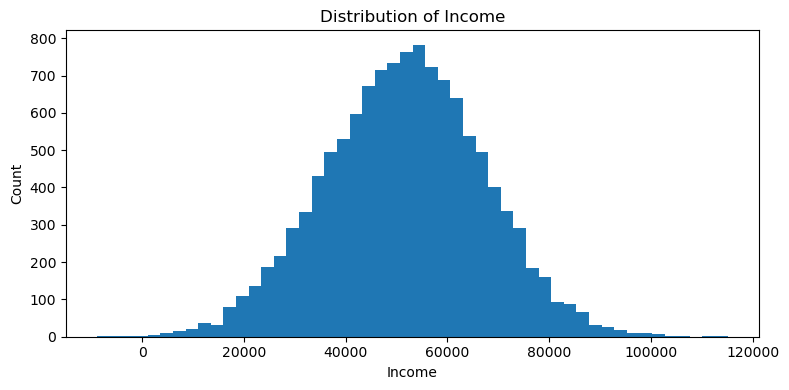

count     12010.000000
mean      51564.201499
std       15633.083296
min       -8786.000000
5%        25432.300000
10%       31381.100000
25%       41094.000000
50%       51858.000000
75%       62046.000000
90%       71365.000000
95%       76845.550000
max      115084.000000
Name: Income, dtype: float64

In [28]:
income = df["Income"].dropna()

plt.figure(figsize=(8,4))
plt.hist(income, bins=50)
plt.title("Distribution of Income")
plt.xlabel("Income")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

income.describe(percentiles=[.05,.1,.25,.5,.75,.9,.95])


In [29]:
# feature enginerig "credit_mean" and "credit_gap", "price_to_income"
df["credit_mean"] = df[["CreditScore1", "CreditScore2"]].mean(axis=1, skipna=True)
df["credit_gap"]  = (df["CreditScore1"] - df["CreditScore2"]).abs()
df["price_to_income"] = df["MedianVehiclePrice"] / (df["Income"] + 1)

In [30]:
log_cols = [
    "InboundCallCount","InboundChatCount","InboundEmailCount","TotalInboundCallLength",
    "DeviceCount","NumberSavedVehicles","NumberSearches","UniqueModels",
    "VehicleVelocity1","VehicleVelocity15","VehicleVelocity30","TradeInValueAmount"
]

for c in log_cols:
    df[f"log1p_{c}"] = np.log1p(df[c])


In [31]:
cat_cols = ["CensusGeoRegionAddress","LeadSource","ModeDeviceType","ModeVehicleType",
            "PhoneType","ServiceProvider","AgeCategory","InboundCallContact","ClicksQuintile"]

for c in cat_cols:
    print("\n", c)
    print("n_unique:", df[c].nunique(dropna=False))
    print(df[c].value_counts(dropna=False).head(10))



 CensusGeoRegionAddress
n_unique: 4
CensusGeoRegionAddress
South        4784
Midwest      3597
West         2382
Northeast    1247
Name: count, dtype: int64

 LeadSource
n_unique: 3
LeadSource
Website                7852
ThirdPartyListing      3607
ThirdPartyFinancing     551
Name: count, dtype: int64

 ModeDeviceType
n_unique: 3
ModeDeviceType
mobile     5495
desktop    3557
tablet     2958
Name: count, dtype: int64

 ModeVehicleType
n_unique: 4
ModeVehicleType
Car      3589
Truck    3576
Van      3090
SUV      1755
Name: count, dtype: int64

 PhoneType
n_unique: 3
PhoneType
PostPaid    9611
Landline    1440
Prepaid      959
Name: count, dtype: int64

 ServiceProvider
n_unique: 5
ServiceProvider
Verizon    3597
TMobile    3001
ATT        2358
Sprint     1860
Other      1194
Name: count, dtype: int64

 AgeCategory
n_unique: 5
AgeCategory
45-55    3602
18-35    3087
35-45    2350
55-65    1788
65+      1183
Name: count, dtype: int64

 InboundCallContact
n_unique: 4
InboundCallContact
a

In [32]:
# one-hot encode categorical columns (keeps 0/1 ints)
cat_cols = [
    "CensusGeoRegionAddress","LeadSource","ModeDeviceType","ModeVehicleType",
    "PhoneType","ServiceProvider","AgeCategory","InboundCallContact","ClicksQuintile"
]

df_ohe = pd.get_dummies(df, columns=cat_cols, drop_first=False, dtype=int)


In [33]:
# make sure engineered cols exist in df_ohe
engineered = ["credit_mean", "credit_gap", "price_to_income"]
for c in engineered:
    if c in df.columns and c not in df_ohe.columns:
        df_ohe[c] = df[c]

# target
y = df_ohe["sold"].astype(int)

# columns to DROP (leakage / IDs / campaign / post-outcome / redundant)
drop_cols = [
    # target + post-outcome
    "sold", "saledatetime", "sale_date", "StickerPrice", "Odometer", "sticker_price",
    # IDs / keys / timestamps
    "userid", "PhoneNumber_hashed", "accountcreationdatetime", "accountcreationdate",
    # outbound call process (treatment leakage)
    "OBCallDateTime", "Contacted", "advocate_id", "CallDuration", "call_sec", "attempted", "only_contacted",
    # campaign/email variables you decided to exclude
    "OutboundCallCount", "OutboundEmailCount", "OutboundEmail", "AttributedEmail",
    # replace CreditScore1/2 with mean (+ gap)
    "CreditScore1", "CreditScore2",
    # engineered segment flags (redundant with continuous vars)
    "high_credit", "high_income",
]

X = df_ohe.drop(columns=[c for c in drop_cols if c in df_ohe.columns])

print("X shape:", X.shape, "y shape:", y.shape)
print("Any non-numeric cols left?", X.select_dtypes(exclude="number").columns.tolist())


X shape: (12010, 84) y shape: (12010,)
Any non-numeric cols left? []


# Predictive Modeling (XGBoost for Prioritization)

### Train/Validation/Test Split + Baseline XGBoost

The data is split into train, validation, and test sets using stratification to preserve the class balance. An XGBoost classifier is then trained as a baseline predictive model, using probability outputs and standard classification metrics (ROC-AUC, PR-AUC, confusion matrix, precision/recall/F1 at a default threshold) to establish initial performance on held-out data.

In [34]:
# split (same as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val,  y_train, y_val  = train_test_split(X_train, y_train, test_size=0.1765, random_state=42, stratify=y_train)

In [35]:
# 2) handle class imbalance (optional, usually helps)
pos = y_train.sum()
neg = (y_train == 0).sum()
scale_pos_weight = float(neg / pos)

In [36]:
clf = XGBClassifier(
    n_estimators=5000,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    early_stopping_rounds=200,     # <-- move it HERE
)

clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=200,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=5000, n_jobs=-1,
              num_parallel_tree=None, ...)

In [37]:

best_iter = getattr(clf, "best_iteration", None)
print("Best iteration:", best_iter)

proba = clf.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, proba))
print("PR-AUC: ", average_precision_score(y_test, proba))
print("\nConfusion matrix (thr=0.5):\n", confusion_matrix(y_test, pred))
print("\nReport (thr=0.5):\n", classification_report(y_test, pred, digits=4))


Best iteration: 341
ROC-AUC: 0.726019887255233
PR-AUC:  0.6159642612276611

Confusion matrix (thr=0.5):
 [[801 338]
 [231 432]]

Report (thr=0.5):
               precision    recall  f1-score   support

           0     0.7762    0.7032    0.7379      1139
           1     0.5610    0.6516    0.6029       663

    accuracy                         0.6842      1802
   macro avg     0.6686    0.6774    0.6704      1802
weighted avg     0.6970    0.6842    0.6882      1802



### SMOTE + XGBoost (Class Imbalance Handling) 
To address class imbalance, SMOTE is applied to the training data to synthetically oversample the minority class while leaving validation and test sets untouched. The same XGBoost workflow is rerun to evaluate whether balancing the training distribution improves minority-class detection and overall ranking performance (especially PR-AUC), compared with the baseline model.

In [38]:
# show NaN counts for ALL columns
na_counts = X.isna().sum().sort_values(ascending=False)
print(na_counts.to_string())


log1p_TradeInValueAmount            1
EmailVerified                       0
HasBureauError                      0
GeneratedTerms                      0
InboundCall                         0
InboundChat                         0
InboundEmail                        0
IsDealSeeker                        0
IsDirtLover                         0
IsDreamer                           0
IsGreen                             0
IsResearcher                        0
MultipleEmail                       0
ReferralAttachment                  0
TradeInValueGenerated               0
InboundCallCount                    0
InboundChatCount                    0
InboundEmailCount                   0
TotalInboundCallLength              0
HasStartedPurchase                  0
BureauIncome                        0
DeviceCount                         0
Income                              0
FraudScore                          0
MedianVehiclePrice                  0
NumberSavedVehicles                 0
NumberSearch

In [39]:
X["log1p_TradeInValueAmount"] = X["log1p_TradeInValueAmount"].fillna(0)

In [42]:
# split (same as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val,  y_train, y_val  = train_test_split(X_train, y_train, test_size=0.1765, random_state=42, stratify=y_train)

# 2) SMOTE on TRAIN only
sm = SMOTE(random_state=42, k_neighbors=5)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# 3) Train XGBoost (turn off scale_pos_weight since SMOTE balances)
clf_smote = XGBClassifier(
    n_estimators=5000,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="aucpr",          # focus more on PR-AUC
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=200
)

clf_smote.fit(X_train_sm, y_train_sm, eval_set=[(X_val, y_val)], verbose=False)

# 4) Evaluate
proba = clf_smote.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

print("Best iteration:", getattr(clf_smote, "best_iteration", None))
print("ROC-AUC:", roc_auc_score(y_test, proba))
print("PR-AUC: ", average_precision_score(y_test, proba))
print("\nConfusion matrix (thr=0.5):\n", confusion_matrix(y_test, pred))
print("\nReport (thr=0.5):\n", classification_report(y_test, pred, digits=4))


Best iteration: 215
ROC-AUC: 0.7219359682820923
PR-AUC:  0.6062831418446264

Confusion matrix (thr=0.5):
 [[967 172]
 [361 302]]

Report (thr=0.5):
               precision    recall  f1-score   support

           0     0.7282    0.8490    0.7839      1139
           1     0.6371    0.4555    0.5312       663

    accuracy                         0.7042      1802
   macro avg     0.6826    0.6522    0.6576      1802
weighted avg     0.6947    0.7042    0.6910      1802



### Hyperparameter Tuning + Final XGBoost
A randomized hyperparameter search is run over key XGBoost settings (e.g., max_depth, min_child_weight, gamma, subsample, colsample_bytree, reg_alpha, reg_lambda), selecting the best configuration based on validation PR-AUC and using early stopping to reduce overfitting. The best model is then evaluated on the test set, achieving TEST ROC-AUC = 0.732 and TEST PR-AUC = 0.617, with best validation PR-AUC = 0.631 and best parameters: {'subsample': 1.0, 'reg_lambda': 2.0, 'reg_alpha': 0.5, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 0, 'colsample_bytree': 0.6}.

In [39]:
xgb_x = X.copy()
# 1) split once (same style as before)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1765, random_state=42, stratify=y_train
)

# 2) class weight 
pos = y_train.sum()
neg = (y_train == 0).sum()
spw = float(neg / pos)

# 3) sample a small set of configs
param_dist = {
    "max_depth": [2,3,4,5,6],
    "min_child_weight": [1,3,5,7,10],
    "gamma": [0, 0.5, 1, 2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0, 0.01, 0.1, 0.5],
    "reg_lambda": [0.5, 1.0, 2.0, 5.0],
}

candidates = list(ParameterSampler(param_dist, n_iter=15, random_state=42))

best = {"ap": -1, "params": None, "model": None}

for i, p in enumerate(candidates, 1):
    clf = XGBClassifier(
        n_estimators=4000,
        learning_rate=0.03,
        objective="binary:logistic",
        eval_metric="aucpr",         # optimize PR-AUC
        tree_method="hist",
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=spw,
        early_stopping_rounds=150,   # in constructor (works with your version)
        **p
    )
    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    val_proba = clf.predict_proba(X_val)[:, 1]
    ap = average_precision_score(y_val, val_proba)
    auc = roc_auc_score(y_val, val_proba)

    print(f"{i:02d}/15  val PR-AUC={ap:.4f}  val ROC-AUC={auc:.4f}  best_iter={getattr(clf,'best_iteration',None)}  params={p}")

    if ap > best["ap"]:
        best.update(ap=ap, params=p, model=clf)

print("\nBEST on VAL:")
print("val PR-AUC:", best["ap"])
print("best params:", best["params"])

# 4) evaluate best on TEST
best_model = best["model"]
test_proba = best_model.predict_proba(X_test)[:, 1]
print("\nTEST metrics:")
print("TEST ROC-AUC:", roc_auc_score(y_test, test_proba))
print("TEST PR-AUC: ", average_precision_score(y_test, test_proba))


01/15  val PR-AUC=0.6195  val ROC-AUC=0.7367  best_iter=143  params={'subsample': 0.8, 'reg_lambda': 5.0, 'reg_alpha': 0.01, 'min_child_weight': 3, 'max_depth': 2, 'gamma': 1, 'colsample_bytree': 0.8}
02/15  val PR-AUC=0.6307  val ROC-AUC=0.7358  best_iter=35  params={'subsample': 1.0, 'reg_lambda': 2.0, 'reg_alpha': 0.5, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 0, 'colsample_bytree': 0.6}
03/15  val PR-AUC=0.6242  val ROC-AUC=0.7428  best_iter=111  params={'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alpha': 0.01, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 0, 'colsample_bytree': 0.8}
04/15  val PR-AUC=0.6192  val ROC-AUC=0.7364  best_iter=203  params={'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'min_child_weight': 10, 'max_depth': 2, 'gamma': 2, 'colsample_bytree': 1.0}
05/15  val PR-AUC=0.6274  val ROC-AUC=0.7412  best_iter=168  params={'subsample': 0.8, 'reg_lambda': 2.0, 'reg_alpha': 0, 'min_child_weight': 7, 'max_depth': 3, 'gamma': 0, 'colsample_bytree': 0.8}


### Ranking Performance (Tuned XGBoost)

In [40]:

test_proba = test_proba  # from your tuned run

y_test_s = y_test.reset_index(drop=True)
p_test_s = pd.Series(test_proba)

def topk_precision(y_true, scores, k):
    n = int(np.ceil(k * len(y_true)))
    idx = np.argsort(scores)[::-1][:n]
    return y_true.iloc[idx].mean()

def topk_capture(y_true, scores, k):
    n = int(np.ceil(k * len(y_true)))
    idx = np.argsort(scores)[::-1][:n]
    return y_true.iloc[idx].sum() / y_true.sum()

for k in [0.05, 0.10, 0.20, 0.30]:
    print(
        f"Top {int(k*100):>2}%  precision={topk_precision(y_test_s, p_test_s, k):.3f}  "
        f"capture={topk_capture(y_test_s, p_test_s, k):.3f}"
    )


Top  5%  precision=0.802  capture=0.110
Top 10%  precision=0.713  capture=0.195
Top 20%  precision=0.679  capture=0.370
Top 30%  precision=0.623  capture=0.508


These ranking results evaluate how well the tuned XGBoost model prioritizes customers by predicted purchase probability. When customers are sorted by model score, the top 5% has precision 0.802, meaning about 80% of customers in the highest-ranked 5% are actual purchasers, and this slice captures about 11% of all purchasers in the test set. Expanding to larger call lists trades off precision for coverage: the top 10% has precision 0.713 and captures 19.5% of purchasers, the top 20% has precision 0.679 and captures 37.0%, and the top 30% has precision 0.623 and captures 50.8%. This shows the model concentrates purchasers near the top of the ranking, which supports using the score to prioritize outreach under limited calling capacity.

### Feature Engineering: Affordability Alignment & Behavioral Ratios

Additional ratio-based features were created to capture affordability alignment and browsing behavior signals, including dreamer_gap (MedianVehiclePrice vs Income), mileage_price_ratio (MedianVehicleMileage / MedianVehiclePrice), searches_per_saved (NumberSearches / (NumberSavedVehicles + 1)), and velocity30_per_search (VehicleVelocity30 / (NumberSearches + 1)), using safe denominators to avoid division issues. These features were added to the one-hot encoded modeling table and the tuned XGBoost model (best hyperparameters from validation) was retrained using the same split and early stopping setup. Test performance remained essentially unchanged (ROC-AUC ≈ 0.732 and PR-AUC ≈ 0.620), indicating that these engineered ratios did not add meaningful incremental predictive signal beyond the existing feature set for this dataset.

In [41]:

# --- 1) create features on df (safe denominators) ---
df["dreamer_gap"] = df["MedianVehiclePrice"] - df["Income"]

df["mileage_price_ratio"] = df["MedianVehicleMileage"] / (df["MedianVehiclePrice"] + 1)

df["searches_per_saved"] = df["NumberSearches"] / (df["NumberSavedVehicles"] + 1)

df["velocity30_per_search"] = df["VehicleVelocity30"] / (df["NumberSearches"] + 1)

# (optional safety) replace any inf just in case (should be none with +1)
for c in ["mileage_price_ratio","searches_per_saved","velocity30_per_search"]:
    df[c] = df[c].replace([np.inf, -np.inf], np.nan).fillna(0)

# --- 2) add to df_ohe (since you already one-hot encoded earlier) ---
for c in ["dreamer_gap","mileage_price_ratio","searches_per_saved","velocity30_per_search"]:
    df_ohe[c] = df[c]

# --- 3) rebuild X exactly like before ---
y = df_ohe["sold"].astype(int)

drop_cols = [
    "sold","saledatetime","sale_date","StickerPrice","Odometer","sticker_price",
    "userid","PhoneNumber_hashed","accountcreationdatetime","accountcreationdate",
    "OBCallDateTime","Contacted","advocate_id","CallDuration","call_sec","attempted","only_contacted",
    "OutboundCallCount","OutboundEmailCount","OutboundEmail","AttributedEmail",
    "CreditScore1","CreditScore2","high_credit","high_income",
]

X = df_ohe.drop(columns=[c for c in drop_cols if c in df_ohe.columns])

print("X shape:", X.shape)


X shape: (12010, 88)


In [42]:

# 1) same split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1765, random_state=42, stratify=y_train
)

# class weight
pos = y_train.sum()
neg = (y_train == 0).sum()
spw = float(neg / pos)

# 2) train with your best params
best_params = {'subsample': 1.0, 'reg_lambda': 2.0, 'reg_alpha': 0.5,
               'min_child_weight': 5, 'max_depth': 5, 'gamma': 0,
               'colsample_bytree': 0.6}

clf = XGBClassifier(
    n_estimators=4000,
    learning_rate=0.03,
    objective="binary:logistic",
    eval_metric="aucpr",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=spw,
    early_stopping_rounds=150,
    **best_params
)

clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# 3) test metrics
test_proba = clf.predict_proba(X_test)[:, 1]
print("Best iteration:", getattr(clf, "best_iteration", None))
print("TEST ROC-AUC:", roc_auc_score(y_test, test_proba))
print("TEST PR-AUC: ", average_precision_score(y_test, test_proba))

Best iteration: 42
TEST ROC-AUC: 0.7320762437479889
TEST PR-AUC:  0.6197187086909483


**Summary**

Among the modeling approaches tested, the tuned XGBoost model selected via randomized hyperparameter search provided the strongest and most stable out-of-sample performance, so it is used as the primary model for prioritization. Hyperparameter tuning improved generalization by selecting settings that maximized validation PR-AUC while using early stopping to reduce overfitting, and the final model achieved solid test ROC-AUC/PR-AUC. Ranking-based evaluation further shows the model concentrates purchasers near the top of the score distribution (high top-k precision with increasing capture as k grows), which supports using the predicted probabilities to produce an ordered calling list under limited outreach capacity.

# Interpretable Modeling (Logistic Regression for Call Impact)



the goal is not to maximize prediction accuracy, but to describe and quantify the relationship between outbound calling and the probability of purchase, while controlling for confounding customer attributes that influence both who gets called and who buys (e.g., credit, income, engagement, lead source, and browsing behavior). I will use an interpretable model (logistic regression) where the key coefficient represents the estimated association between being called (attempted/contacted) and purchase likelihood, and I will extend it with interaction terms to test whether the call effect varies across customer segments (e.g., by credit or income). The results will be reported using clear effect summaries (odds ratios and/or probability lift with confidence intervals), and I will explicitly discuss why this adjusted association should not automatically be interpreted as causal without stronger identification (e.g., random assignment).

### Checking variabbles before running logisticregression

**Multicollinearity Check (VIF)**: Multicollinearity is checked using variance inflation factors (VIF) on the full design matrix used for the interpretable logistic regression (treatment indicator plus numeric, binary, and one-hot encoded categorical controls). Several predictors show very high VIFs due to redundancy and strong correlation, particularly among overlapping credit/quality proxies and vehicle/browsing preference variables. To improve coefficient stability and interpretability, the most collinear predictors are removed iteratively and VIF is recalculated after each removal. The process stops once the treatment variable (attempted) and the remaining controls have acceptable VIF levels (most below ~10, with a small number slightly above but still usable), reducing coefficient instability without over-pruning the feature set.

Dropped columns: CreditScore1, CreditScore2, credit_mean, MedianVehicleFuelEcon, MedianVehicleMileage, MedianVehiclePrice, VehicleVelocity30, FraudScore

In [45]:
#  numeric controls (dummies excluded)
cols = [
    "GeneratedTerms","HasStartedPurchase","IsResearcher","IsDealSeeker",
    "TradeInValueGenerated","EmailVerified","credit_gap","MedianVehicleFuelEcon",
    "log1p_NumberSearches","log1p_NumberSavedVehicles","log1p_DeviceCount",
    "MedianVehiclePrice"
]

X_vif = (X[[c for c in cols if c in X.columns]]
         .replace([np.inf, -np.inf], np.nan)
         .dropna())

vif = (pd.DataFrame({
          "feature": X_vif.columns,
          "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
      })
      .sort_values("VIF", ascending=False))

print(vif.to_string(index=False))


                  feature       VIF
     log1p_NumberSearches 22.372861
       MedianVehiclePrice 21.473402
    MedianVehicleFuelEcon 16.693951
        log1p_DeviceCount  9.675825
log1p_NumberSavedVehicles  7.650303
               credit_gap  2.718509
           GeneratedTerms  2.306670
            EmailVerified  1.787553
    TradeInValueGenerated  1.747327
       HasStartedPurchase  1.609414
             IsResearcher  1.287284
             IsDealSeeker  1.100446


### Imbalance Handling: SMOTE + Logistic Regression


An interpretable logistic regression model is fit using an ImbPipeline that applies median imputation for missing values, SMOTE oversampling on the training set to address class imbalance, and standardization before fitting the classifier. The model is evaluated on a held-out test set using ROC-AUC, PR-AUC, and a threshold-based confusion matrix/report. In this run, performance is modest (TEST ROC-AUC ≈ 0.580, TEST PR-AUC ≈ 0.425), indicating limited ranking separation compared to the tuned XGBoost model.

In [46]:
# Build X, y for interpretable model: attempted + selected controls + one-hot dummies
target = "sold"
treat  = "attempted"

cols = [
    "GeneratedTerms","HasStartedPurchase","IsResearcher","IsDealSeeker",
    "TradeInValueGenerated","EmailVerified","credit_gap","MedianVehicleFuelEcon",
    "log1p_NumberSearches","log1p_NumberSavedVehicles","log1p_DeviceCount",
    "MedianVehiclePrice"
]

dummy_prefixes = (
    "CensusGeoRegionAddress_", "LeadSource_", "ModeDeviceType_", "ModeVehicleType_",
    "PhoneType_", "ServiceProvider_", "AgeCategory_", "InboundCallContact_", "ClicksQuintile_"
)

dummy_cols = [c for c in df_ohe.columns if c.startswith(dummy_prefixes)]
feat_cols  = [treat] + [c for c in cols_q9 if c in df_ohe.columns] + dummy_cols

X = df_ohe[feat_cols]
y = df_ohe[target].astype(int)

# If X is sparse, densify for SMOTE
X_mat = X.to_numpy() if hasattr(X, "to_numpy") else np.asarray(X)
if hasattr(X_mat, "toarray"):
    X_mat = X_mat.toarray()

# Train/test split (SMOTE ONLY on train via pipeline)
X_train, X_test, y_train, y_test = train_test_split(
    X_mat, y, test_size=0.2, random_state=42, stratify=y
)

pipe = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("smote", SMOTE(random_state=42)),
    ("scaler", StandardScaler(with_mean=False)),
    ("logreg", LogisticRegression(max_iter=5000, solver="lbfgs"))
])

pipe.fit(X_train, y_train)

# Metrics + confusion matrix
proba = pipe.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

roc = roc_auc_score(y_test, proba)
pr  = average_precision_score(y_test, proba)

print(f"TEST ROC-AUC: {roc:.4f}")
print(f"TEST PR-AUC:  {pr:.4f}\n")

print("Confusion matrix (thr=0.5):")
print(confusion_matrix(y_test, pred), "\n")

print("Classification report (thr=0.5):")
print(classification_report(y_test, pred, digits=4))


TEST ROC-AUC: 0.5798
TEST PR-AUC:  0.4249

Confusion matrix (thr=0.5):
[[736 782]
 [323 561]] 

Classification report (thr=0.5):
              precision    recall  f1-score   support

           0     0.6950    0.4848    0.5712      1518
           1     0.4177    0.6346    0.5038       884

    accuracy                         0.5400      2402
   macro avg     0.5564    0.5597    0.5375      2402
weighted avg     0.5930    0.5400    0.5464      2402



### Imbalance Handling: Class-Weighted Logistic Regression (No SMOTE)

A second logistic regression is trained using the same preprocessing (median imputation and scaling) but replaces SMOTE with class_weight="balanced" to handle imbalance through weighted loss rather than synthetic samples. Test metrics remain similar (TEST ROC-AUC ≈ 0.581, TEST PR-AUC ≈ 0.424), suggesting that weighting improves training balance without materially changing overall discrimination for this feature set, while keeping coefficients interpretable and stable for explaining call impact.

In [47]:

X_mat = X.to_numpy()
y_vec = y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X_mat, y_vec, test_size=0.2, random_state=42, stratify=y_vec
)

pipe = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),  # ok for logistic
    ("logreg", LogisticRegression(
        max_iter=5000, solver="lbfgs", class_weight="balanced"
    ))
])

pipe.fit(X_train, y_train)

proba = pipe.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

print(f"TEST ROC-AUC: {roc_auc_score(y_test, proba):.4f}")
print(f"TEST PR-AUC:  {average_precision_score(y_test, proba):.4f}\n")
print("Confusion matrix (thr=0.5):")
print(confusion_matrix(y_test, pred), "\n")
print(classification_report(y_test, pred, digits=4))


TEST ROC-AUC: 0.5807
TEST PR-AUC:  0.4238

Confusion matrix (thr=0.5):
[[749 769]
 [321 563]] 

              precision    recall  f1-score   support

           0     0.7000    0.4934    0.5788      1518
           1     0.4227    0.6369    0.5081       884

    accuracy                         0.5462      2402
   macro avg     0.5613    0.5651    0.5435      2402
weighted avg     0.5979    0.5462    0.5528      2402



# Calling Strategy and ROI


Use the best-performing model to decide whether the outbound calling program should continue and, if so, generate an ordered calling list that specifies which customers to attempt and in what priority order. The strategy is evaluated by estimating the expected improvement in conversion relative to the current approach and translating that lift into expected revenue impact, then comparing expected benefit to dialing cost ($0.10 per attempt) to determine whether the program remains profitable under the proposed targeting policy.

### Model Chosen (Ranking-Based Targeting)

Because the operational problem is capacity-constrained outreach, the model is selected based on ranking quality (PR-AUC and top-k precision/capture) rather than a single fixed classification threshold. XGBoost consistently outperforms logistic regression on these metrics, making it the most effective choice for prioritizing calls. While threshold-based performance can appear moderate, the model’s value is strongest as a ranking tool: sorting customers by predicted purchase probability concentrates buyers near the top of the list. For example, targeting the top 10% achieves ~0.71 precision while capturing ~20% of all buyers, and expanding to the top 20–30% increases capture to ~37–51% while maintaining solid precision (~0.62–0.68). These results support using XGBoost for prioritization and triage—who to call first and how far down the ranked list to call—rather than relying on a single cutoff probability for a hard call/no-call decision.


In [58]:
# ---------- Rank ALL customers using your already-built xgb_x ----------
df_base = globals().get("df_full", None)
if df_base is None:
    df_base = globals().get("df", None)
assert df_base is not None, "I couldn't find df_full or df in memory."

# pick the id column 
id_col = "userid" if "userid" in df_base.columns else "UserID"
assert id_col in df_base.columns, f"Couldn't find userid/UserID in df. Available cols: {list(df_base.columns)[:20]}..."

# ensure X_all columns match what the model expects
feature_cols = list(xgb_x.columns)
X_all = xgb_x.reindex(columns=feature_cols, fill_value=0)

# align ids to X_all rows
if len(df_base) == len(X_all):
    ids = df_base[id_col].reset_index(drop=True).values
else:
    # align by index if lengths differ
    ids = df_base.loc[X_all.index, id_col].values

# score + rank
scores = best_model.predict_proba(X_all)[:, 1]

ranked_calls = (
    pd.DataFrame({id_col: ids, "score": scores})
      .sort_values("score", ascending=False)
      .reset_index(drop=True)
)
ranked_calls["rank"] = np.arange(1, len(ranked_calls) + 1)

# mark top K% to call (capacity)
TOP_PCT = 0.10
K = int(np.ceil(TOP_PCT * len(ranked_calls)))
ranked_calls["call_flag"] = (ranked_calls["rank"] <= K).astype(int)

ranked_calls.head(30)


,userid,score,rank,call_flag
0,4309,0.713064,1,1
1,7168,0.711488,2,1
2,6504,0.710812,3,1
3,727,0.710600,4,1
4,11015,0.708532,5,1
5,3116,0.707822,6,1
6,9369,0.707420,7,1
7,4374,0.706872,8,1
8,4916,0.705769,9,1
9,11209,0.705058,10,1
